In [1]:
import numpy as np
import pandas as pd
import scipy as sc

import os
import glob
from pathlib import Path
import warnings

In [2]:
def list_files_pathlib(
    directory_path, 
    verbose=None,
):
    """
    Lists files using the modern pathlib module and returns them as a list.
    
    Args:
        directory_path (str): The path to the directory to inspect.
        verbose (bool): If True, prints detailed output to the console. 
                        Defaults to False.

    Returns:
        list: A list of file names (str) found in the directory. 
              Returns an empty list if the directory is not found or is empty.
    """

    import os
    import glob
    from pathlib import Path
    import warnings
    
    if verbose is None:
        verbose = False
    elif verbose is True:
        print(f"--- Listing contents in '{directory_path}' using pathlib ---")
    
    try:

        # Step 1 - Check if the directory_path is valid
        # Note - this code is almost too bulletproof? I love it :D
        path_obj = Path(directory_path)
        if not path_obj.exists():
            warnings.warn(f"Directory not found at '{directory_path}'", UserWarning)
            return []  # Return empty list on error
        if not path_obj.is_dir():
            warnings.warn(f"The path '{directory_path}' is not a directory.", UserWarning)
            return []  # Return empty list on error
        entries = sorted(list(path_obj.iterdir()))
        if not entries:
            warnings.warn(f"The directory at '{directory_path}' is empty.", UserWarning)
            return []  # Return empty list on error
        

        # Step 2 - Collect all the files in the directory
        files_list = []
        entries = sorted(list(path_obj.iterdir()))
        for entry in entries:
            if entry.is_file():
                files_list.append(str(entry))
            if verbose:
                entry_type = "dir" if entry.is_dir() else "file"
                print(f"- {entry.name:<20} ({entry_type})")        
        return files_list

    except Exception as e:
        warnings.warn(f"An unexpected error occurred: {e}", RuntimeWarning)
        return [] # Return empty list on unexpected exception
    finally:
        if verbose:
            print("-" * 50)


In [3]:
filenames = list_files_pathlib("HIPed_Stellite1")
filenames

['HIPed_Stellite1/EDS_Point_Carbide1.txt',
 'HIPed_Stellite1/EDS_Point_Carbide2.txt',
 'HIPed_Stellite1/EDS_Point_Carbide3.txt',
 'HIPed_Stellite1/EDS_Point_SolidSolution1.txt',
 'HIPed_Stellite1/EDS_Point_SolidSolution2.txt',
 'HIPed_Stellite1/EDS_Point_SolidSolution3.txt']

In [4]:
def import_commented_file_to_df(file_path):
    """
    Imports a two-column, comma-separated file into a pandas DataFrame,
    ignoring any lines that start with a '#' character.

    Args:
        file_path (str or file-like object): The full path to the data file 
                                             or a file-like object.
        column_names (list of str): A list of names to assign to the columns.
                                    The number of names should match the number
                                    of columns in the data.

    Returns:
        pandas.DataFrame: A DataFrame containing the imported data. 
                          Returns an empty DataFrame if an error occurs 
                          (e.g., file not found).
    """

    import pandas as pd

    try:

        df = pd.read_csv(
            file_path,
            header=None,
            names=["keV", "cps/eV"],
            sep=',',
            comment='#'
        )

        df.set_index("keV", inplace=True)
        
        return df
    except FileNotFoundError:
        print(f"Error: The file was not found at '{file_path}'")
        return pd.DataFrame() # Return an empty DataFrame on error
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame() # Return an empty DataFrame on error


import_commented_file_to_df(filenames[0])

cps/eV
keV           
-0.20      0.0
-0.19      0.0
-0.18      0.0
-0.17      0.0
-0.16      0.0
...        ...
 20.23     0.0
 20.24     0.0
 20.25     0.0
 20.26     0.0
 20.27     0.0

[2048 rows x 1 columns]

In [5]:
def import_eds_emsa(file_path: str | Path) -> tuple[pd.DataFrame | None, dict | None]:
    """
    Parses an EMSA/MAS spectral data file robustly, handling common format errors
    and structured multi-line metadata (e.g., ##OXINSTLABEL).

    This function extracts:
    1. Repeatable '##OXINSTLABEL' annotation lines into a 'ANNOTATIONS' dictionary.
    2. Standard metadata from '#' lines into a dictionary.
    3. Spectral data into a pandas DataFrame.

    Args:
        file_path (str or Path): The path to the EMSA file.

    Returns:
        tuple[pd.DataFrame | None, dict | None]: A tuple containing:
            - A DataFrame of the spectral data.
            - A dictionary of the header metadata, including annotations.
        Returns (None, None) if a critical error occurs.
    """

    import pandas as pd
    import io
    import warnings
    from pathlib import Path
    
    metadata = {'ANNOTATIONS': {}}
    data_lines = []
    
    try:
        file_path = Path(file_path)
        with file_path.open('r', encoding='utf-8', errors='ignore') as f:
            
            for i, line in enumerate(f, 1):
                line = line.strip()
                if not line: continue

                # --- Handle element annotation ---
                if line.startswith('##OXINSTLABEL'): 
                    
                    parts = line.split(':', 1)
                    if len(parts) != 2: continue # Skip malformed annotation lines
                    
                    # value_parts: e.g., ['27', '6.930', 'Co']
                    value_parts = [p.strip() for p in parts[1].split(',')]
                    
                    if len(value_parts) == 3:
                        try:
                            atomic_num = int(value_parts[0])
                            energy_kev = float(value_parts[1])
                            element = value_parts[2]

                            # Ensure the element entry exists in the ANNOTATIONS dict
                            if element not in metadata['ANNOTATIONS']:
                                metadata['ANNOTATIONS'][element] = []
                            
                            # Append the structured annotation
                            metadata['ANNOTATIONS'][element].append(energy_kev)
                            
                        except (ValueError, IndexError) as e:
                            warnings.warn(f"Could not parse annotation on line {i}: '{line}'. Reason: {e}", UserWarning)

                # --- Handle standard single-line metadata ---
                elif line.startswith('#'):
                    
                    parts = line[1:].split(':', 1)
                    if len(parts) == 2:
                        key = parts[0].strip().upper()
                        value = parts[1].strip()
                        metadata[key] = value

                # --- Collect potential data lines ---        
                else:
                    data_lines.append(line)

        # --- Sort the collected annotation lists numerically ---
        for element in metadata['ANNOTATIONS']: metadata['ANNOTATIONS'][element].sort()        
        
        # --- Data Parsing and Validation ---
        if not data_lines:
            warnings.warn(f"No data lines found in '{file_path.name}'.", UserWarning)
            return pd.DataFrame(), metadata

        df = pd.read_csv(
            io.StringIO('\n'.join(data_lines)),
            header=None,
            sep=r'\s*,\s*',
            engine='python',
            names=['keV', 'counts'],
            comment='#'
        ).dropna()

        df['keV'] = pd.to_numeric(df['keV'], errors='coerce')
        df['counts'] = pd.to_numeric(df['counts'], errors='coerce')

        original_rows = len(df)
        df.dropna(inplace=True)
        if len(df) < original_rows:
            warnings.warn(f"Removed {original_rows - len(df)} non-numeric data rows.", UserWarning)

        # Please warn if the datalines are missing data for whatever reason.
        if 'NPOINTS' in metadata:
            try:
                try:
                    npoints_meta = int(metadata['NPOINTS'].strip())
                except ValueError:                
                    npoints_meta = int(float(metadata['NPOINTS'].strip()))

                if npoints_meta != len(df):
                    warnings.warn(f"Header #NPOINTS ({npoints_meta}) does not match actual data points ({len(df)}).", UserWarning)
            except ValueError:
                warnings.warn(f"#NPOINTS value '{metadata['NPOINTS']}' is not a valid integer.", UserWarning)

        df.set_index('keV', inplace=True)
        return df, metadata

    except FileNotFoundError:
        warnings.warn(f"Error: The file was not found at '{file_path}'", UserWarning)
        return None, None
    except Exception as e:
        warnings.warn(f"An unexpected error occurred: {e}", RuntimeWarning)
        return None, None



In [6]:
eds_df, eds_metadata = import_eds_emsa(filenames[0])
print(eds_df)
eds_metadata

        counts
keV           
-0.20      0.0
-0.19      0.0
-0.18      0.0
-0.17      0.0
-0.16      0.0
...        ...
 20.23     0.0
 20.24     0.0
 20.25     0.0
 20.26     0.0
 20.27     0.0

[2048 rows x 1 columns]


{'ANNOTATIONS': {'Co': [0.678, 0.694, 0.776, 6.93, 7.65],
  'W': [0.21,
   0.222,
   1.379,
   1.775,
   2.035,
   7.388,
   8.398,
   8.724,
   9.673,
   9.962,
   11.286,
   11.608],
  'Cr': [0.5, 0.573, 5.415, 5.947],
  'C': [0.277]},
 'FORMAT': 'EMSA/MAS Spectral Data File',
 'VERSION': '1.0',
 'TITLE': 'Spectrum 1',
 'DATE': '21-JUL-2025',
 'TIME': '12:52',
 'OWNER': '',
 'NPOINTS': '2048.0',
 'NCOLUMNS': '1.0',
 'XUNITS': 'keV',
 'YUNITS': 'counts',
 'DATATYPE': 'XY',
 'XPERCHAN': '0.01',
 'OFFSET': '-0.2',
 'SIGNALTYPE': 'EDS',
 'CHOFFSET': '20.0',
 'LIVETIME': '30.0',
 'REALTIME': '30.062997818',
 'BEAMKV': '20.0',
 'PROBECUR': '0.0',
 'MAGCAM': '5000.0',
 'XTILTSTGE': '0.0',
 'AZIMANGLE': '0.0',
 'ELEVANGLE': '35.0',
 'XPOSITION MM': '-3.9563',
 'YPOSITION MM': '1.9538',
 'ZPOSITION MM': '14.8410',
 '#OXINSTPT': '2',
 '#OXINSTSTROB': '76.71',
 '#OXINSTELEMS': '27,74,24,6',
 'SPECTRUM': 'Spectral Data Starts Here',
 'ENDOFDATA': ''}

<Axes: xlabel='keV'>

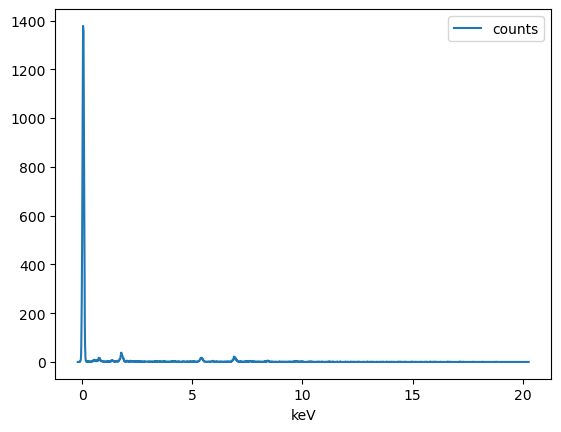

In [7]:
eds_df.plot()

In [140]:
def plot_eds_spectrum(
    df: pd.DataFrame, 
    metadata: dict, 
    fig=None, 
    ax=None, 
    label=None,
    color=None,
):
    """
    Plots the EDS spectrum and annotates elemental peaks on a given or new axis.

    Args:
        df (pd.DataFrame): DataFrame containing the spectral data with 'keV' as the index
                           and 'counts' as a column.
        metadata (dict): Dictionary containing metadata, including 'ANNOTATIONS'
                         for elemental peaks.
        fig (matplotlib.figure.Figure, optional): The figure to plot on. If None, a new
                                                   figure is created. Defaults to None.
        ax (matplotlib.axes.Axes, optional): The axes to plot on. If None, a new
                                             axes object is created. Defaults to None.
    
    Returns:
        tuple: A tuple containing the figure and axes objects used for plotting.
    """

    import pandas as pd
    import matplotlib.pyplot as plt
    import warnings
    from pathlib import Path
    import io
    
    if df is None or df.empty:
        print("DataFrame is empty or None. Cannot plot.")
        return

    # If no axes are provided, create a new figure and axes
    if ax is None or fig is None:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))
        show_plot = True
    else:
        show_plot = False # Don't call plt.show() if using existing axes

    if label is None: 
        label = "EDS Spectrum"

    if color is None: 
        color = "royalblue"
    

    # Plot the primary spectrum data
    ax.plot(
        df.index, df['counts'], 
        label=label, color=color, linewidth=1,
    )

    # --- Labeling and Formatting ---
    ax.set_xlabel('Energy (keV)', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set a lower limit for y-axis to avoid cutting off baseline
    ax.set_ylim(bottom=0, top=90)
    ax.set_xlim(left=0, right=12)

    # Create a legend, avoiding duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=10)

    if show_plot:
        plt.tight_layout()
        plt.show()

    return fig, ax


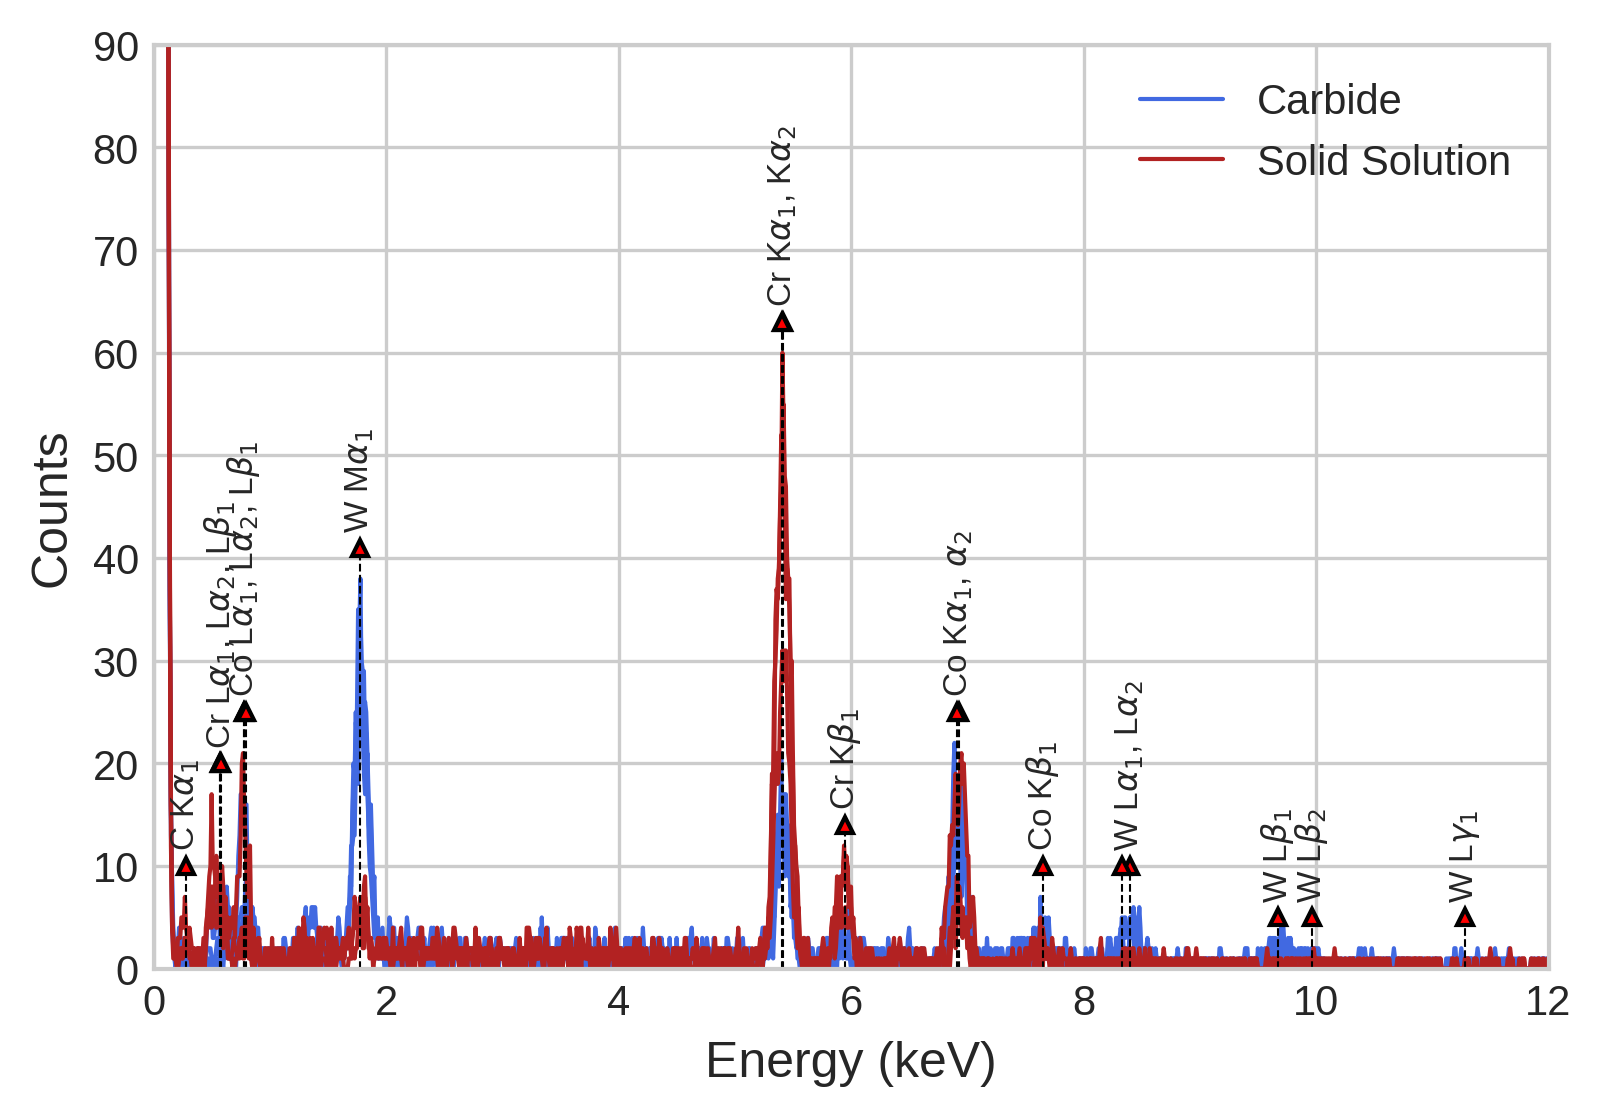

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import io

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# --- Read and Plot the data ---

eds_dfs = [None for filename in filenames]
eds_metadatas = [None for filename in filenames]

for i, filename in enumerate(filenames[:3]):
    eds_df, eds_metadata = import_eds_emsa(filename)
    if eds_df is not None:
        eds_dfs[i] = eds_df
        eds_metadatas[i] = eds_metadata
        plot_eds_spectrum(eds_df, eds_metadata, fig=fig, ax=ax, label="Carbide", color="royalblue")

for i, filename in enumerate(filenames[3:]):
    eds_df, eds_metadata = import_eds_emsa(filename)
    if eds_df is not None:
        eds_dfs[i+3] = eds_df
        eds_metadatas[i+3] = eds_metadata
        plot_eds_spectrum(eds_df, eds_metadata, fig=fig, ax=ax, label="Solid Solution", color="firebrick")

# --- Annotate Elemental Peaks ---
#for df, metadata in zip(eds_dfs, eds_metadatas):
#    if 'ANNOTATIONS' in eds_metadata and eds_metadata['ANNOTATIONS']:           

# Find unique elements
annotations = [meta['ANNOTATIONS'] for meta in eds_metadatas]
nested_list = [list(annotation.keys()) for annotation in annotations]
unique_elements = list(set(item for sublist in nested_list for item in sublist))


    
maximum_profile = np.max([np.interp(np.arange(0,20,0.05), eds_df.index, eds_df['counts']) for eds_df in eds_dfs], axis=0)

lines = {}

lines["C"] = [
    (r'K$\alpha_1$', 0.277, 10)                            ##OXINSTLABEL: 6, 0.277, C
]



##OXINSTLABEL: 24, 0.500, Cr
lines["Cr"] = [
    (r'K$\alpha_1$, K$\alpha_2$', 5.41472, 63),            ##OXINSTLABEL: 24, 5.415, Cr
    (None, 5.405509, 63), 
    (r'K$\beta_1$',  5.94671, 14),                         ##OXINSTLABEL: 24, 5.947, Cr
    (r'L$\alpha_1$, L$\alpha_2$, L$\beta_1$', 0.5728, 20), ##OXINSTLABEL: 24, 0.573, Cr
    (None, 0.5728, 20), 
    (None, 0.5828, 20), 
]



##OXINSTLABEL: 27, 0.694, Co
##OXINSTLABEL: 27, 0.678, Co
lines["Co"] = [
    (r'K$\alpha_1$, $\alpha_2$', 6.93032, 25),              ##OXINSTLABEL: 27, 6.930, Co
    (None, 6.91530, 25),     
    (r'K$\beta_1$',  7.64943, 10),                          ##OXINSTLABEL: 27, 7.650, Co    
    (r'L$\alpha_1$, L$\alpha_2$, L$\beta_1$',  0.7762, 25), ##OXINSTLABEL: 27, 0.776, Co
    (None,  0.7762, 25),     
    (None,  0.7914, 25), 
]



##OXINSTLABEL: 74, 8.724, W

##OXINSTLABEL: 74, 11.608, W
##OXINSTLABEL: 74, 7.388, W

##OXINSTLABEL: 74, 2.035, W
##OXINSTLABEL: 74, 1.379, W
##OXINSTLABEL: 74, 0.222, W
##OXINSTLABEL: 74, 0.210, W
lines["W"] = [
    (r'K$\alpha_1$', 59.31824, 20), 
    (r'K$\alpha_2$', 57.9817, 20), 
    (r'K$\beta_1$',  67.2443, 20),         
    (r'L$\alpha_1$, L$\alpha_2$', 8.3976, 10), ##OXINSTLABEL: 74, 8.398, W
    (None, 8.3352, 10), 
    (r'L$\beta_1$',  9.67235, 5),              ##OXINSTLABEL: 74, 9.673, W
    (r'L$\beta_2$',  9.9615, 5),               ##OXINSTLABEL: 74, 9.962, W
    (r'L$\gamma_1$',  11.2859, 5),             ##OXINSTLABEL: 74, 11.286, W
    (r'M$\alpha_1$',  1.7754, 41),             ##OXINSTLABEL: 74, 1.775, W
] 

# Iterate through your 'lines' dictionary to plot each element's lines
for element, spectral_lines in lines.items():
    for line_name, energy, y_height in spectral_lines:
        # Only plot lines that are within the energy range of your spectrum
        if 0 <= energy < 15:
                        
            # Plot the vertical line from the x-axis to the spectrum
            ax.plot(
                [energy, energy], 
                [0, y_height], 
                linestyle='--', color='black', linewidth=0.5)

            # Plot the triangle marker at the top of the line
            ax.plot(
                energy, 
                y_height, 
                marker='^', markersize=4, color='red', markeredgecolor='black')

            if line_name is not None:
                # Add the text label for the element and line type
                ax.text(energy, 
                    y_height+1.5, 
                    f'{element} {line_name}', rotation=90,
                    verticalalignment='bottom', horizontalalignment='center', fontsize=8)

plt.show()